<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/Quantization_Aware_Training_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this QAT, we are using float input and output tensors. Hence, the compiler leaves a quantized operation at the beginning of the graph and dequantize the output at the end. 

Both quantization and dequantization runs on the CPU instead of the Edge TPU. Thus, some amount of latency is added due to data format conversion.

Ref: https://coral.ai/docs/edgetpu/models-intro/#compiling

In [1]:
#! pip uninstall -q -y tensorflow
! pip install tensorflow==2.6.0
! pip install keras==2.6.0
#! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization
#! pip install numpy --upgrade

     |████████████████████████████████| 458.3 MB 10 kB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=1b111ce4ccc34becf526bba53934f8149d7f1d3a1fcb47dc9184bae3fbdfd027
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=39af7e6133bb9740d189ce731108d18c02799721fef82df9bac90f24c40aa680
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Successfully uninstalled wrapt-1.13.3
  Attempting uninstall: flatbuffers

In [27]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
import os
import tempfile
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from google.colab import files

# Keras imports 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout,
                                     Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D)
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Accuracy

In [3]:
print(tf.__version__)

2.6.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [6]:
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW1.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW2.h5')
model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW3.h5')

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
test_loss, test_acc = model.evaluate(test_data, test_label)

print("Tested Acc:", test_acc)

16/16 [==============================] - 17s 961ms/step - loss: 0.1552 - accuracy: 0.9440
Tested Acc: 0.9440000057220459


### Clone and fine-tune pre-trained model with quantization aware training

In [9]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

opt = Adam(learning_rate=0.00001) # use a lower learning rate to prevent overfitting quickly
q_aware_model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

q_aware_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapperV2) (None, 112, 112, 32) 929         quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_Conv1 (QuantizeWrapper (None, 112, 112, 32) 129         quant_Conv1[0][0]                
______________________________________________________________________________________________

In [10]:
q_training = q_aware_model.fit(train_data, train_label, epochs= 10, validation_data=(test_data, test_label), verbose=1)

Epoch 1/10
63/63 [==============================] - 430s 7s/step - loss: 0.6539 - accuracy: 0.7795 - val_loss: 0.3429 - val_accuracy: 0.8900
Epoch 2/10
63/63 [==============================] - 417s 7s/step - loss: 0.2818 - accuracy: 0.8985 - val_loss: 0.2208 - val_accuracy: 0.9200
Epoch 3/10
63/63 [==============================] - 478s 8s/step - loss: 0.2014 - accuracy: 0.9325 - val_loss: 0.2016 - val_accuracy: 0.9320
Epoch 4/10
63/63 [==============================] - 486s 8s/step - loss: 0.1892 - accuracy: 0.9350 - val_loss: 0.1927 - val_accuracy: 0.9220
Epoch 5/10
63/63 [==============================] - 424s 7s/step - loss: 0.1292 - accuracy: 0.9570 - val_loss: 0.1742 - val_accuracy: 0.9320
Epoch 6/10
63/63 [==============================] - 418s 7s/step - loss: 0.1067 - accuracy: 0.9680 - val_loss: 0.1355 - val_accuracy: 0.9400
Epoch 7/10
63/63 [==============================] - 421s 7s/step - loss: 0.0929 - accuracy: 0.9665 - val_loss: 0.1522 - val_accuracy: 0.9520
Epoch 8/10
63

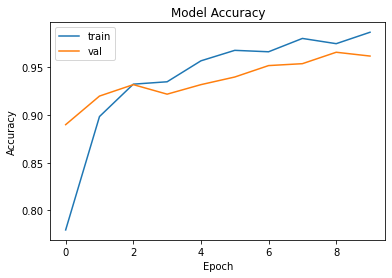

In [11]:
plt.plot(q_training.history['accuracy'])
plt.plot(q_training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

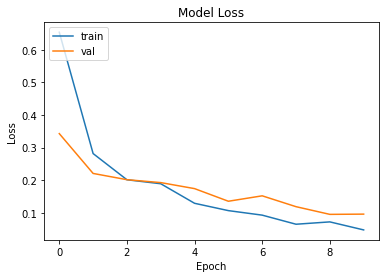

In [12]:
plt.plot(q_training.history['loss'])
plt.plot(q_training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
_, baseline_model_accuracy = model.evaluate(
    test_data, test_label, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_data, test_label, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9440000057220459
Quant test accuracy: 0.9620000123977661


### Create Quantized model for TFLite Backend

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

In [15]:
# 'wb': file is opened for writing in binary mode
with open('mobilenet_v2_sound_classification_float_qat.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

###Compare accuracy

In [16]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0] # for one input data
  tensor_index = input_details['index'] # tensor index in the interpreter
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = input

def classify_audio(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke() # invoke the interpreter; must set input size, allocate tensor and fill values before calling this
  output_details = interpreter.get_output_details()[0] # for one output data
  output = interpreter.get_tensor(output_details['index']) # obtains output tensor in numpy array
  top_1 = np.argmax(output) # obtain most probable output
  return top_1

In [17]:
interpreter = tf.lite.Interpreter('mobilenet_v2_sound_classification_float_qat.tflite')
interpreter.allocate_tensors() # tflite pre-plans tensor allocations to optimize inference

In [28]:
# Obtain tflite prediction outputs

tflite_pred = []
ground_truth = test_label

for i in range(len(test_data)):
  prediction = classify_audio(interpreter, test_data[i])
  tflite_pred.append(prediction)

print(tflite_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 

In [29]:
# Computes the frequency with which prediction matches ground truth
tflite_acc = Accuracy()
tflite_acc(ground_truth, tflite_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.962>

In [30]:
print("Quant TF Lite accuracy: {:.5%}".format(tflite_acc.result().numpy()))

Quant TF Lite accuracy: 96.20000%


In [31]:
print('Quant TF test accuracy: {:.5%}'.format(q_aware_model_accuracy))

Quant TF test accuracy: 96.20000%


### Compare size of float TFLite model and quantized TFLite model

In [32]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: /tmp/tmpzzo_rm37/assets


INFO:tensorflow:Assets written to: /tmp/tmpzzo_rm37/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Float model in Mb: 8.527118682861328
Quantized model in Mb: 2.6019821166992188


### Compiling model for Edge TPU

In [33]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  70472      0 --:--:-- --:--:-- --:--:-- 70472
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.

In [34]:
# Compile model
! edgetpu_compiler mobilenet_v2_sound_classification_float_qat.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1292 ms.

Input model: mobilenet_v2_sound_classification_float_qat.tflite
Input size: 2.60MiB
Output model: mobilenet_v2_sound_classification_float_qat_edgetpu.tflite
Output size: 2.78MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.98MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_sound_classification_float_qat_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 70
Number of operations tha

In [35]:
! edgetpu_compiler -s mobilenet_v2_sound_classification_float_qat.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1259 ms.

Input model: mobilenet_v2_sound_classification_float_qat.tflite
Input size: 2.60MiB
Output model: mobilenet_v2_sound_classification_float_qat_edgetpu.tflite
Output size: 2.78MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.98MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_sound_classification_float_qat_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 70
Number of operations tha

### Download model compiled for Edge TPU

In [36]:
files.download('mobilenet_v2_sound_classification_float_qat_edgetpu.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>